# Mask Workflow Example

#### Jeffrey Feng (j1feng@ucsd.edu), August 2021

## 1. Introduction

Geodata is able to process geospatial data to extract cutouts over specified geographies. Built off the [rasterio library](https://rasterio.readthedocs.io/en/latest/quickstart.html), the mask module imports rasters and shapefiles, merges and flattens multiple layers together, and extracts subsetted cutout data from merged masks and shapefiles.

Its current functionalities in details are:

- Creating mask object, adding and manipulating layers
- Openning shapefile and adding shape features as a layer
- Merging and flattening layers
- Extracting shapes from mask
- Saving and Loading masks

## 2. Setup

To start, import the required dependencies:

In [45]:
import geodata
import numpy as np
import logging
logging.basicConfig(level=logging.INFO)
from geodata.mask import show
import matplotlib.pyplot as plt

To launch a logger for detailed debugging, run:

In [2]:
import logging
logging.basicConfig(level=logging.INFO)

We use [cartopy](https://scitools.org.uk/cartopy/docs/latest/tutorials/using_the_shapereader.html#cartopy.io.shapereader.Reader) to download some common administrative region shapes, but user-provided shapefiles will also work:

In [3]:
import cartopy.io.shapereader as shpreader

We would use the following geotiff and shape files to run this demo:
    
#### Elevation_Slope.tif 

It is the Elevation and slope data from https://developers.google.com/earth-engine/datasets/catalog/CGIAR_SRTM90_V4?hl=en);
We will use the IGBP classification ('LC_Type1') which has 17 different land use characterizations (the corresponding data thus takes values from 1.0 to 17.0).

- MODIS_China.tif (MODIS land cover data, which uses satellite remote sensing data to estimate the land use type on an annual basis. See: https://lpdaac.usgs.gov/products/mcd12q1v006/)

- UNEP_WDPA_China shapefiles








In [4]:
modis_path = 'MODIS_China.tif'

elevation_path = 'china_elevation.tif'
slope_path = 'china_slope.tif'

enep_shape_path = 'china_shape/UNEP_WDPA_China.shp'

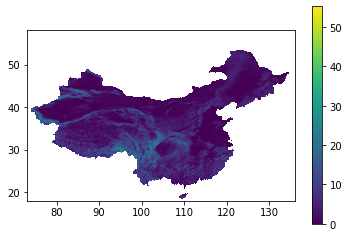

INFO:geodata.mask:Please remember to close the file with .close()


<open DatasetReader name='china_slope.tif' mode='r'>

In [5]:
geodata.mask.open_tif('china_slope.tif', show=True)

## 3. Creating mask object, adding and manipulating layers

The mask object consists of multiple layers and manipulations performed on them. To add a layer, the four methods below perform same functions. A user may add a layer to the mask by specifying paths when a new instance is created, or use the `add_layer` method. We will add the following two files: `elevation_slope.tif`, and `MODIS_China.tif` to the `China` mask, and name them `slope` and `modis` layers.

In [6]:
china = geodata.Mask("China", layer_path = elevation_path)
china.rename_layer('china_elevation', 'elevation')
china.add_layer(modis_path, layer_name = 'modis')

INFO:geodata.mask:Layer china_elevation added to the mask China.
INFO:geodata.mask:Raster MODIS_China.tif has been reprojected to EPSG:4326 CRS.
INFO:geodata.mask:Layer modis added to the mask China.


In [7]:
china = geodata.Mask("China")
china.add_layer(layer_path = {'elevation': elevation_path,
                             'modis': modis_path})

INFO:geodata.mask:Layer elevation added to the mask China.
INFO:geodata.mask:Raster MODIS_China.tif has been reprojected to EPSG:4326 CRS.
INFO:geodata.mask:Layer modis added to the mask China.


In [8]:
china = geodata.Mask("China", layer_path = [elevation_path, modis_path],
             layer_name = ['elevation', 'modis'])

INFO:geodata.mask:Layer elevation added to the mask China.
INFO:geodata.mask:Raster MODIS_China.tif has been reprojected to EPSG:4326 CRS.
INFO:geodata.mask:Layer modis added to the mask China.


In [9]:
china = geodata.Mask("China", layer_path = {'elevation': elevation_path,
                              'modis': modis_path})

INFO:geodata.mask:Layer elevation added to the mask China.
INFO:geodata.mask:Raster MODIS_China.tif has been reprojected to EPSG:4326 CRS.
INFO:geodata.mask:Layer modis added to the mask China.


Display the mask object in the jupyter notebook:

In [10]:
china

Mask China: 
2 layers: ['elevation', 'modis'].
No merged_mask ready. 
No shape has been extracted. 
Mask has not been saved/updated. 

Each mask object has several attributes:
- `layers`: a dictionary of name (key)  - rasterio file opener (values). The <\open DatasetReader> can be the input for many other mask methods for the module.  
- `merged_mask`: the merged and flatten mask of its layers, the merged raster from `layers`
- `shape_mask`: similar to the `layers` attribute, but a dictionary of extracted shapes from the merged mask by default. Users may also extracted shape masks from specified layers in `self.layers`.
- `saved`: whether this mask object has been saved locally.
- `mask_dir`: the directory to save the mask object, by default it should be the mask dir in config.py.

Show the `slope` layer in mask `china`. The `show` method will always try to show the proper latitude and longitude.

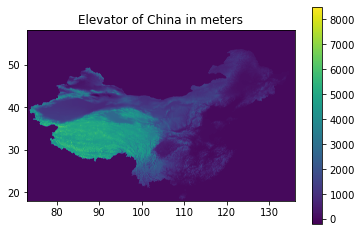

In [11]:
show(china.layers['elevation'], title = 'Elevator of China in meters')

Some useful methods for the layers:

- `china.get_res()`: get resolution of each layer, in lat-lon coordinates
- `china.get_res(product = True)`: get grid cell size, in product of lat-lon coordinate differences
- `china.get_bounds()`: get bounds, in lat-lon coordinates

In [12]:
china.get_bounds()

{'elevation': BoundingBox(left=72.99253346658085, bottom=17.994777314571174, right=136.0003674947241, top=58.23031889028454),
 'modis': BoundingBox(left=44.81844021698865, bottom=17.092253634655307, right=179.98824371508368, top=58.38850413860287)}

Note that the modis layer has a very different bounding box then the slope layer in lat-lon coordinate system. This is because the modis layer was converted to the lat-lon CRS from a different CRS when it was added to the object. The following section will explore the behind scene.

### 3.1 CRS conversion, trimming, cropping (if necessary)

Method `open_tif` can open a layer without adding it to the layer, this allows us to visualize it before-hand. It is a good practice to close the raster after openning it to avoid writing permission conflict issues.

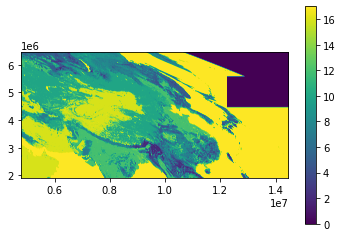

INFO:geodata.mask:Please remember to close the file with .close()


In [13]:
modis_openner = geodata.mask.open_tif(modis_path, show=True)
modis_openner.close()

We can use `remove_layer` method to remove a layer to mask `china`. This method will properly close the raster file.

In [14]:
china.remove_layer('modis')

The `add_layer` method incorporates CRS conversion. When the user pass in a path to a raster file, the program will automatically convert the CRS of the raster to the lat-lon CRS by default.

Note that this method will overwrite the layer by default, if it is in the object already, unless the user specifies `replace=True`. 

The method will automatically trim the all-zero columns/rows. By default, the paramater `trim` is set to `True`. If we do not set it to True, we might generate a converted raster with new CRS but many all-zero columns and rows.

INFO:geodata.mask:Raster MODIS_China.tif has been reprojected to EPSG:4326 CRS.
INFO:geodata.mask:Layer modis added to the mask China.


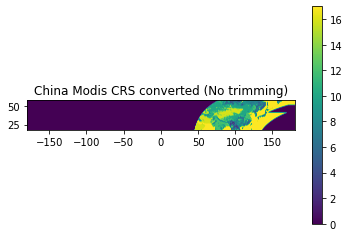

In [15]:
china.add_layer(modis_path, 'modis', trim = False)
show(china.layers['modis'], title = 'China Modis CRS converted (No trimming)')

We can also **arbitrary** crop a raster/layer: method `crop_layer` can take either starting indices of top/left, ending indices of right/bottom, or coordinates values in lat/long to trim the raster.

We also have a method `crop_raster` (`geodata.mask.crop_raster`) similarly to `crop_layer` but we can have any raster as input, which indicates that users do not need to add a raster as a layer to call that method. (Similar method: `trim_layer`/`trim_raster`, `binarize_layer`/`binarize_raster`)

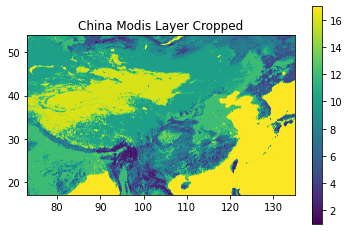

In [16]:
china.crop_layer('modis', bounds = (73, 17, 135, 54))
show(china.layers['modis'], title = 'China Modis Layer Cropped')

The line below performs the same function with the code block above in arbitrary cropping the modis layer.

In [17]:
china.layers['modis'] = geodata.mask.crop_raster(china.layers['modis'], (73, 17, 135, 54))

### 3.2 Filter a layer

The mask module also support filtering a layer based on a minimum (lower) boundary, maximum (upper) boundary. Users can also specify a list of values where its values will be selected from the layer. 

In the `filter_raster` method, a user may specify any of the `value` (the list of numberic values in the raster array to be selected), `max_bound`, and `min_bound` parameters to selected desired values. If the parameter `binarize` is False (by default), the method will return the original values of the raster that satisfy the conditions, otherwise the method will return 1 for the values that satisfy the conditions.

#### a). Select categorical values from modis layer

Since the modis layer have 17 distinct values, we may want to create a layer of binary values, indicating unavailable land as 0, and available land as 1.

We wish to create a mask where :

- all forested areas (values 1-5) are 0 (i.e., unsuitable)
- all urban areas (13) are 0
- all others are 1 (for now)


Let us use method `filter_raster` to create a layer of `modis_filtered` binary mask, where 1, 2, 3, 4, 5, and 13 will be unavailable land, therefore we need to take in the rest of the values to make them 1 (available).


In [18]:
values = list(set(range(1, 18)) - set([1, 2, 3, 4, 5, 13]))
values

[6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17]

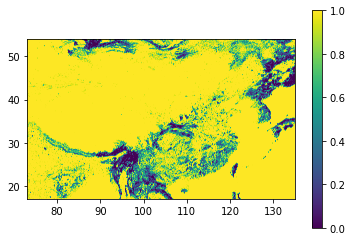

In [19]:
china.layers['modis_filtered'] = geodata.mask.filter_raster(
                china.layers['modis'], 
                binarize = True,
                values = values)
china.remove_layer('modis')
show(china.layers['modis_filtered'])

#### b). Filter elevation layer

Because we cannot build renewable energy in area with high elevation, let us set the constraint from the `elevation` layer, by using elevation < 4000m at 1 and else as 0. The result layer `elevation_filtered` will have only 1 and 0 as unique values.

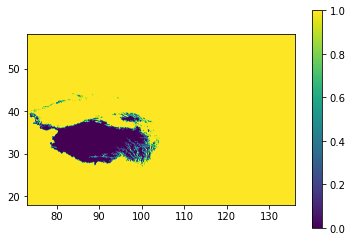

In [20]:
china.filter_layer('elevation', 
                   dest_layer_name = 'elevation_filtered', 
                   max_bound = 4000,
                   binarize = True)
china.remove_layer('elevation')
show(china.layers['elevation_filtered'])

#### b). Filter slope layer

We also cannot build renewable energy in area with large slope angle, so let us set another constraint from the `slope` layer from the slope tif file, by using slope < 20% at 1 and else as 0. The result layer `slope_filtered` will have only 1 and 0 as unique values.

Add the slope raster to the china mask.

INFO:geodata.mask:Layer slope added to the mask China.


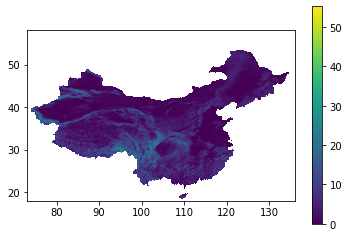

In [21]:
china.add_layer(slope_path, layer_name = 'slope')
show(china.layers['slope'])

Filter the raster, delete the old slope layer.

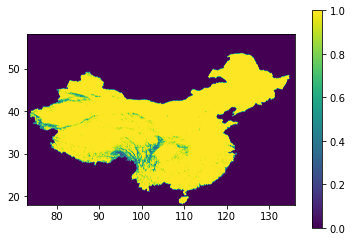

In [22]:
china.filter_layer('slope', 
                   dest_layer_name = 'slope_filtered', 
                   max_bound = 20,
                   binarize = True)
china.remove_layer('slope')
show(china.layers['slope_filtered'])

## 4. Openning shapefile and adding shape features as a layer

To load the environmental protected shapefiles as a layer in China mask, we could load the shapes with the `get_shape` method to a dictionary or geodataframe (by default, the result will be a geopandas dataframe, which will preserve all the shapes with duplicate key names). Then, we can just load the shapes into a python dictionary as a input for `add_shape_layer` method.

There are more examples of the `get_shape` method later in this demo where we want to extract the chinese provinces from the mask.

In [23]:
protected_area_shapes = geodata.mask.get_shape(enep_shape_path)
print(len(protected_area_shapes))
protected_area_shapes.head()

1145


,NaN,shapes
0,0,"POLYGON ((120.064214586534 30.27986235986009, ..."
1,1,"POLYGON ((82.06393000006949 43.30747999950245,..."
2,2,"(POLYGON ((91.4075900001784 29.87829999994511,..."
3,3,"POLYGON ((82.28715000027233 43.33979999977021,..."
4,4,"POLYGON ((91.11178000064655 36.12380999983168,..."


There are 1145 shapes, but we want to add all the shapes to one new layer instead of 1145 new layers. Therefore, in the `add_shape_layer` method, we will specify a `combine_name` so that the program will combine the features to one layer with the `combine_name` as its layer name.

We will also use `reference layer = 'slope'` so the new shape layer will have the same dimension with the `slope` layer. If the mask is empty and does not contain any layer, the user will have to specify the `resolution` parameter for the raster layer dimension.

By default, this method will have paramater `invert` that defaults to `True`, and generate 1 for area covered by the shape, and 0 for the area outside of the shape. In this use case, however, we want 0 for area inside of the shape as they are the environmental protected area. We will specify `invert = False`.

INFO:geodata.mask:Layer protected added to the mask China.


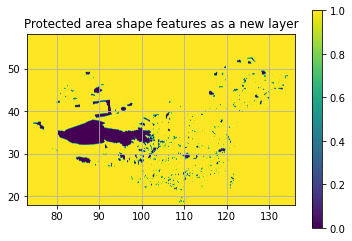

In [24]:
china.add_shape_layer(protected_area_shapes, 
                      reference_layer = 'slope_filtered', 
                      combine_name = 'protected',
                      invert = False)
show(china.layers['protected'], 
     title = 'Protected area shape features as a new layer',
     grid = True)

We can also with the parameter `buffer` in `add_shape_layer` method to create an approximate representation of all points within a given distance of the shape object. In the method call below, `buffer = 150` indicates that we will mark any area extending outside of the shape with 150 km in a round style.

Note that since the unit of the original shape was in lat-lon coordinates, when we add the buffer, we will need to have a CRS that has meter as unit. The program will convert the shapes to that CRS, add the buffer around shapes, then convert it back to the lat-lon CRS system. By default, we used "EPSG:6933", an equal area projection CRS as the `buffer_crs` parameter to allow the program to add buffer in kilometer. As a result, `buffer = 20` parameter will return area also within the radius of **20km** of the shapes.

INFO:geodata.mask:Layer protected_with_buffer added to the mask China.


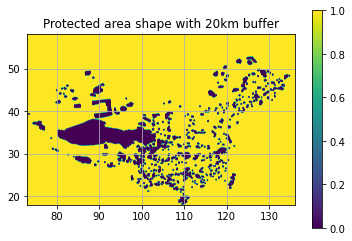

In [25]:
km_buffer = 20

china.add_shape_layer(protected_area_shapes, 
                      reference_layer = 'slope_filtered', 
                      combine_name = 'protected_with_buffer',
                      buffer = km_buffer,
                      invert = False)

show(china.layers['protected_with_buffer'], 
     title = f"Protected area shape with {km_buffer}km buffer",
     grid = True)

china.remove_layer('protected_with_buffer')

## 5. Eliminate Small Suitable Area

## 5. Merging and flattening layers

`merge_layer` method is important for merging all the layers, or the specified layers, into one single mask in object attribute called `merged_mask`.

It merges multiple layers together and flatten it using either **and** (default) or **sum** method, saving the result to `self.merged_mask` by default. Geospatial bounds and resolution of a new output file are in the units of the input file coordinate reference system, but by default, we will use the resolution of the layer with the best (finest) resolution for the output bounds/resolution, unless a reference layer is provided. In this case, the resolution of the merged_mask is the same with the `modis_filtered` layer. 

In [26]:
china.get_res()

{'modis_filtered': (0.006363926718366056, 0.006364039220827179),
 'elevation_filtered': (0.008983152841195215, 0.008983152841195215),
 'slope_filtered': (0.008983152841195215, 0.008983152841195215),
 'protected': (0.008983152841195215, 0.008983152841195215)}

In [27]:
china.merge_layer(attribute_save = False, show = False).res

(0.006363926718366056, 0.006364039220827179)

### 5.1 binary AND method

By default, the `merge_layer` method will use a binary 'and' method: if any of the n grid cells of the n layers at the same location have 0, then the returned `self.merged_layer` will also have 0 at that location. In other words, if all the layers indicate that a land is not unavailable (!=0), the merged result will have value 1.

`merge_layer` may also take in an optional parameter `layers`, which is a list of layer names stored in the object. If users do not wish to create the final merged mask with all layers, they can specify which layers to use. If the user do not want to save the result of this method to the `merged_mask` attribute, the user can specify `attribute_save = False`. 

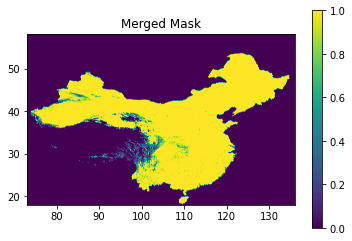

<open DatasetReader name='/vsimem/a443bef4-f4c2-4287-90e3-39d15bfb07c0/a443bef4-f4c2-4287-90e3-39d15bfb07c0.tif' mode='r'>

In [28]:
china.merge_layer(attribute_save = False, layers = ['slope_filtered', 'elevation_filtered'])

Try a different reference layer.

In [29]:
china

Mask China: 
4 layers: ['modis_filtered', 'elevation_filtered', 'slope_filtered', 'protected'].
No merged_mask ready. 
No shape has been extracted. 
Mask has not been saved/updated. 

In [30]:
china.merge_layer(layers = ['elevation_filtered', 'modis_filtered'], reference_layer = 'elevation_filtered', show = False)

INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


Now the result of the `merged_mask` method is saved to `china.merged_mask`, and the resolution of the `merged_mask` is the same with the `elevation_filtered` because it is the reference layer, although it does not have the best resolution among the provided layers.

In [31]:
china.merged_mask.res

(0.008983152841195215, 0.008983152841195215)

### 5.2 sum method

The sum method will add up the values from all the layers. We can also customize the weights. The behind scene of this method is that it multiplys each layers with the corresponding weight, and add the in-memory temporary layers together. When there is o weight dictionary provided, all the layers for merging will have weights of 1 by default

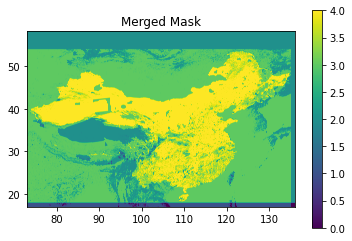

INFO:geodata.mask:Overwriting current merged_mask.
INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


In [32]:
china.merge_layer(method = 'sum')

This distribution is completely arbitrary for the purpose of demonstration of the module:
- elevation_filtered: 15%, slope_filtered: 10%, modis_filtered: 30%, protected 45%

The weights do not need to have a total of 1.

We can also trim the border of the merged mask since not 4 layers have the same boundary, and the border values are not useful. We can set the parameter `trim = True`.

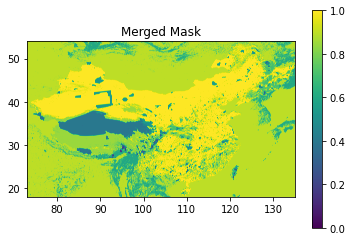

INFO:geodata.mask:Overwriting current merged_mask.
INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


In [33]:
china.merge_layer(method = 'sum', weights = {
    'elevation_filtered': 0.15,
    'slope_filtered': 0.1,
    'modis_filtered': 0.3,
    'protected': 0.45
}, trim = True)

Let's say after generate a `merged_mask` with continous value, we decide that each grid cell needs to have at minimum value of 0.8 to be considered "suitable" (or 1). We can apply the `filter_raster` method on the `merged_mask` attribute of our mask object once again and overwrite it.

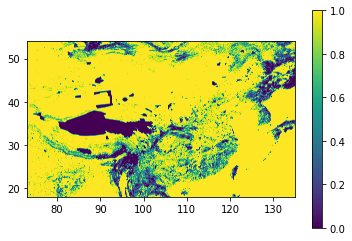

In [34]:
china.merged_mask = geodata.mask.filter_raster(china.merged_mask, min_bound = 0.8, binarize = True)
show(china.merged_mask)

For the purpose of this demonstration, we will select the `AND` method for the final merged_mask.

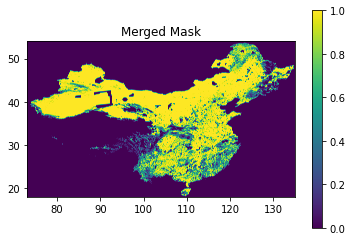

INFO:geodata.mask:Overwriting current merged_mask.
INFO:geodata.mask:Merged Mask saved as attribute 'merged_mask'.


In [53]:
china.merge_layer(trim = True)

## 5. Eliminate Small Suitable Area

However, one realistic problem we might have with the new merged mask is that we might end up having many small connected grid cells that are marked suitable but surrounded by the unsuitable region. We cannot use a region for renewable energy construction if its area is too small and it is not connected to other large suitable regions. The `eliminate_small_area` method will remove the small connected suitable regions by transforming the merged mask raster to polygons/shapes, calculating the area of each polygon, and filtering out polygons that are smaller than a given threshold. 

By default, `eliminate_small_area` uses the merged mask raster and return a new raster, unless input/output layers are specified by `layer_name` and `dest_layer_name`. 

By default, its `area_value` parameter is 1, indicating that we are only interested in find all the groups of cells with value 1 (suitable) for elimination. We specify the threshold with the `area_km2` parameter.

[11/10/2021 update: This method may take a very long time to run, see more detailed performance notes in https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.rasterize]

For example, if we focus on Guangdong province in Southern China merged mask, we notice that there are many light dots in the ocean that are marked as suitable. We want to exclude these small regions.

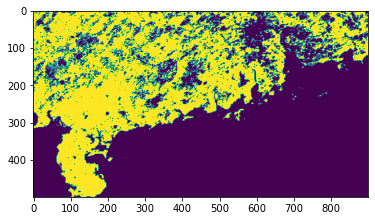

In [57]:
plt.imshow(china.merged_mask.read(1)[4800:5300, 5700:6600])

Call `eliminate_small_area` to Remove all the connected suitable region shapes under 100 km^2.

In [38]:
china.merged_mask = geodata.mask.eliminate_small_area(china, area_km2 = 100)

INFO:geodata.mask:Reprojecting the raster to EPSG:6933 for equal area calculation.
INFO:geodata.mask:Raster /vsimem/8a285d9f-37ea-45fa-948a-655eeecc4ed9/8a285d9f-37ea-45fa-948a-655eeecc4ed9.tif has been reprojected to EPSG:6933 CRS.
INFO:geodata.mask:Reverting the remaining shapes back to a raster.


There shapes are removed in the new merged_mask.

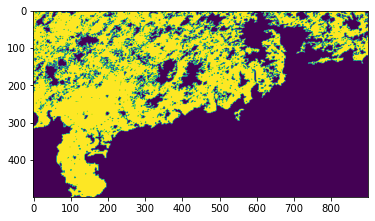

In [59]:
plt.imshow(china.merged_mask .read(1)[4800:5300, 5700:6600])

## 6 Extracting shapes from mask

Extracting shapes from mask is different from section 4, where we added shape features as a new layer. The purpose of shape extraction is that the user may need to generate masks and perform analysis on a state/province level. After generating the `merged_mask` with appropriate mask values, the program can generate the `merged_mask` for every state or province. The result of shape extraction is a dictionary of state_name - state mask pair in `shape_mask` attribute of the mask object. It is still the case that the values in the mask will be 0 outside of the shape in the mask, but inside of the shape of the province/state, we will have the merged_mask values.

Let us get province shapes from `cartopy` and save the path as `prov_path`. This can also be the path to user-supplied shape files.

In [61]:
prov_path = shpreader.natural_earth(resolution='10m', category='cultural', 
                                    name = 'admin_1_states_provinces')
prov_path

'C:\\Users\\fengj\\.local\\share\\cartopy\\shapefiles\\natural_earth\\cultural\\ne_10m_admin_1_states_provinces.shp'

Check attributes in the shapes contained in path `prov_path`.

In [62]:
geodata.mask.shape_attribute(prov_path)

{'featurecla': 'Admin-1 scale rank',
 'scalerank': 3,
 'adm1_code': 'ARG-1309',
 'diss_me': 1309,
 'iso_3166_2': 'AR-E',
 'wikipedia': None,
 'iso_a2': 'AR',
 'adm0_sr': 1,
 'name': 'Entre RÃ\xados',
 'name_alt': 'Entre-Rios',
 'name_local': None,
 'type': 'Provincia',
 'type_en': 'Province',
 'code_local': None,
 'code_hasc': 'AR.ER',
 'note': None,
 'hasc_maybe': None,
 'region': None,
 'region_cod': None,
 'provnum_ne': 10,
 'gadm_level': 1,
 'check_me': 20,
 'datarank': 3,
 'abbrev': None,
 'postal': 'ER',
 'area_sqkm': 0,
 'sameascity': -99,
 'labelrank': 3,
 'name_len': 10,
 'mapcolor9': 3,
 'mapcolor13': 13,
 'fips': 'AR08',
 'fips_alt': None,
 'woe_id': 2344682,
 'woe_label': 'Entre Rios, AR, Argentina',
 'woe_name': 'Entre RÃ\xados',
 'latitude': -32.0275,
 'longitude': -59.2824,
 'sov_a3': 'ARG',
 'adm0_a3': 'ARG',
 'adm0_label': 2,
 'admin': 'Argentina',
 'geonunit': 'Argentina',
 'gu_a3': 'ARG',
 'gn_id': 3434137,
 'gn_name': 'Provincia de Entre Rios',
 'gns_id': -988655,
 

For the `get_shape` method, while the targets list the exact names/value of key_name attributes of the shapes, users may also ignore it and use condition_key and condition_value to find the desired shapes. For example, the call below will find all the shapes of provinces that belongs to China:

In [63]:
china_all_shapes = geodata.mask.get_shape(prov_path,
                        condition_key = 'admin', condition_value = 'China')
china_all_shapes.head()

,NaN,shapes
0,17,"POLYGON ((77.88313195800004 35.43106842000005,..."
1,18,"POLYGON ((78.91769413200012 33.38625783300004,..."
2,118,"POLYGON ((115.9145056560001 47.68391225200013,..."
3,124,"POLYGON ((96.36633990096561 42.72292261928345,..."
4,261,"POLYGON ((101.8679211830001 22.37884185800006,..."


We can also ignore condition, just take three provinces of China by naming them out:

Note that in the previous method call, we ignore `key` parameter as the result can be number indexed. However, the `key` parameter is required when using `targets` list. Since we will also add these provinces as layers with the corresponding layer names, we will obtain a dictionary with the province name as its keys.

In [64]:
china_shapes = geodata.mask.get_shape(prov_path, key = 'name_en',
                         targets = ['Jiangsu', 'Zhejiang', 'Shanghai'],
                         return_dict = True)
china_shapes

{'Zhejiang': <shapely.geometry.multipolygon.MultiPolygon at 0x1c5bc621790>,
 'Shanghai': <shapely.geometry.multipolygon.MultiPolygon at 0x1c5bc621850>,
 'Jiangsu': <shapely.geometry.multipolygon.MultiPolygon at 0x1c5bc6218e0>}

Extract the shapes from the merged_mask.

In [65]:
china.extract_shapes(china_shapes)

INFO:geodata.mask:Extracted shape Zhejiang added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Shanghai added to attribute 'shape_mask'.
INFO:geodata.mask:Extracted shape Jiangsu added to attribute 'shape_mask'.


In [66]:
china

Mask China: 
4 layers: ['modis_filtered', 'elevation_filtered', 'slope_filtered', 'protected'].
Merged_mask merged/flattened. 
3 shape_mask: ['Zhejiang', 'Shanghai', 'Jiangsu']. 
Mask has not been saved/updated. 

## 7. Saving and Loading masks

In [68]:
china.save_mask()

INFO:geodata.mask:Mask China successfully saved at D:/Users/davison_lab_data/masks


Note that since "Mask has been saved", we can now load the layers or shapes with xarray.

INFO:geodata.mask:Please close the shape_mask xarray(s) for further changes of the mask object.


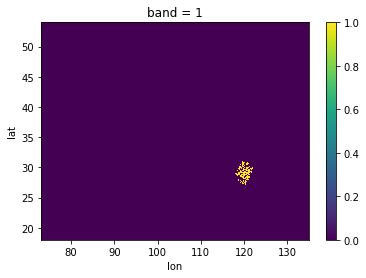

In [69]:
shape_xr_lst = china.load_shape_xr()
shape_xr_lst['Zhejiang'].plot()

Optional: closing all the files when saving the mask. This can avoid possible write permission error.

In [70]:
china.save_mask(close_files = True)

INFO:geodata.mask:Mask China successfully saved at D:/Users/davison_lab_data/masks


Loading a previously saved mask

In [71]:
china_2 = geodata.mask.load_mask("china")

INFO:geodata.mask:Layer ['elevation_filtered', 'modis_filtered', 'protected', 'slope_filtered'] loaded to the mask china.
INFO:geodata.mask:Merged_mask loaded to the mask china.
INFO:geodata.mask:Shape mask ['Jiangsu', 'Shanghai', 'Zhejiang'] loaded to the mask china.


In [72]:
china_2

Mask china: 
4 layers: ['elevation_filtered', 'modis_filtered', 'protected', 'slope_filtered'].
Merged_mask merged/flattened. 
3 shape_mask: ['Jiangsu', 'Shanghai', 'Zhejiang']. 
Mask has been saved. 